<h1 align="center"> Energy demand (Electricity price) Forecasting </h1>
<h2> Methods used in this project : </h2>
<h3> 1. Machine learning : </h3>
<ul>    
<li> XGboost Regressor </li>
<li> XGboost Classifier </li>
</ul>
<h3> 2. Deep learning/Stacked models : </h3>
<ul>    
<li> GRU </li>
<li> LSTM </li>
<li> LSTM-Attention </li>
</ul>
<h3> 3. Hybrid methods: </h3>
<ul>    
<li> GRU-XGBoost </li>
<li> LSTM-Attention-XGBoost </li>
</ul>


In [2]:
# pip install plotly

# tensorflow-addons version depends on the tensorflow and python version of the system,
# you can find the compatibility in this link

# https://stackoverflow.com/questions/61380552/unable-to-import-tensorflow-addons
# !pip install tensorflow-addons==0.19.0

In [3]:
!pip install keras==2.9
!pip install tensorflow==2.8.2
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 417.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 17.6 MB/s eta 0

In [4]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

## Import data

In [5]:
ROOT = '/kaggle/input/elmy-ens'
TRAIN_INPUT = ROOT + "/x_train.csv"
TRAIN_OUTPUT = ROOT + "/y_train.csv"
TEST_INPUT = ROOT + "/x_test.csv"

x_train_raw = pd.read_csv(TRAIN_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
y_train_raw = pd.read_csv(TRAIN_OUTPUT, index_col= 'DELIVERY_START', parse_dates=True)
x_test_raw = pd.read_csv(TEST_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
#datetime data
x_train = x_train_raw.set_index(pd.to_datetime(x_train_raw.index, utc=True))
y_train = y_train_raw.set_index(pd.to_datetime(y_train_raw.index, utc=True))
x_test = x_test_raw.set_index(pd.to_datetime(x_test_raw.index, utc=True))
# data_x = x_train_raw.set_index(pd.to_datetime(x_train_raw.index, utc=True))
# data_y = y_train_raw.set_index(pd.to_datetime(y_train_raw.index, utc=True))


In [6]:
# N = data_x.shape[0]
# x_train = data_x.iloc[:int(0.9*N)]
# y_train = data_y.iloc[:int(0.9*N)]
# x_test = data_x.iloc[int(0.9*N):]
# y_test = data_y.iloc[int(0.9*N):]

In [7]:
print(f"Training data : from {x_train.index.min()} to {x_train.index.max()}")
print(f"Test data : from {x_test.index.min()} to {x_test.index.max()}")

Training data : from 2022-01-01 01:00:00+00:00 to 2023-03-29 21:00:00+00:00
Test data : from 2023-04-01 22:00:00+00:00 to 2023-10-24 21:00:00+00:00


In [8]:
WEATHER_PATH = ROOT + "/donnees-synop-essentielles-omm.csv"
weather = pd.read_csv(WEATHER_PATH, encoding="ISO-8859-1", sep=';', parse_dates=True)

In [9]:
to_drop = ['Temps prÃ©sent', 'Temps passÃ© 1',
       'Temps passÃ© 2', 'NebulositÃ© totale',
       "NÃ©bulositÃ©  des nuages de l' Ã©tage infÃ©rieur",
       "Hauteur de la base des nuages de l'Ã©tage infÃ©rieur",
       "Type des nuages de l'Ã©tage infÃ©rieur",
       "Type des nuages de l'Ã©tage moyen",
       "Type des nuages de l'Ã©tage supÃ©rieur",'GÃ©opotentiel','MÃ©thode de mesure TempÃ©rature du thermomÃ¨tre mouillÃ©','TempÃ©rature du thermomÃ¨tre mouillÃ©',
       'Rafale sur les 10 derniÃ¨res minutes', 'Rafales sur une pÃ©riode',
       'Periode de mesure de la rafale', 'Etat du sol',  'Periode de mesure de la neige fraiche', 'NÃ©bulositÃ© couche nuageuse 1', 'Type nuage 1', 'Hauteur de base 1',
       'NÃ©bulositÃ© couche nuageuse 2', 'Type nuage 2', 'Hauteur de base 2',
       'NÃ©bulositÃ© couche nuageuse 3', 'Type nuage 3', 'Hauteur de base 3',
       'NÃ©bulositÃ© couche nuageuse 4', 'Type nuage 4', 'Hauteur de base 4',
       'Coordonnees', 'Nom', 'Type de tendance baromÃ©trique.1',
       'Temps passÃ© 1.1', 'Temps prÃ©sent.1', 'TempÃ©rature',
       'TempÃ©rature minimale sur 12 heures',
       'TempÃ©rature minimale sur 24 heures',
       'TempÃ©rature maximale sur 12 heures',
       'TempÃ©rature maximale sur 24 heures',
       'TempÃ©rature minimale du sol sur 12 heures', 'Latitude',
       'Longitude', 'Altitude', 'communes (name)', 'communes (code)',
       'EPCI (name)', 'EPCI (code)', 'department (name)', 'department (code)',
       'region (name)', 'region (code)', 'mois_de_l_annee','ï»¿ID OMM station']
weather.drop(to_drop, axis=1, inplace=True)

In [10]:
dict_renaming = { 'Date':'date', 'Pression au niveau mer':'pression',
       'Variation de pression en 3 heures':'pression_var', 'Type de tendance baromÃ©trique':'type_trend_barometrique',
       'Direction du vent moyen 10 mn':'direction_vent', 'Vitesse du vent moyen 10 mn':'vitesse_vent',
       'TempÃ©rature (Â°C)':'temperature', 'Point de rosÃ©e':'point_rosee', 'HumiditÃ©':'humidity',
       'VisibilitÃ© horizontale':'visibility','Pression station':'pression_station',
       'Niveau baromÃ©trique':'niveau_barometrique',
       'Variation de pression en 24 heures' :'pression_var_24h',
       'TempÃ©rature minimale sur 12 heures (Â°C)':'temperature_max_24h',
       'TempÃ©rature minimale sur 24 heures (Â°C)':'temperature_min_24h',
       'TempÃ©rature maximale sur 12 heures (Â°C)':'temperature_max_12h',
       'TempÃ©rature maximale sur 24 heures (Â°C)':'temperature_min_12h',
       'TempÃ©rature minimale du sol sur 12 heures (en Â°C)':'temperature_min_sol_12h',
        'Hauteur totale de la couche de neige, glace, autre au sol':'hauteur_neige_etc',
       'Hauteur de la neige fraÃ®che':'hauteur_neige',
       'PrÃ©cipitations dans la derniÃ¨re heure':'pluie_1h',
       'PrÃ©cipitations dans les 3 derniÃ¨res heures':'pluie_3h',
       'PrÃ©cipitations dans les 6 derniÃ¨res heures':'pluie_6h',
       'PrÃ©cipitations dans les 12 derniÃ¨res heures':'pluie_12h',
       'PrÃ©cipitations dans les 24 derniÃ¨res heures':'pluie_24h',
       'PhÃ©nomÃ¨ne spÃ©cial 1':'phenomene_special_1', 'PhÃ©nomÃ¨ne spÃ©cial 2':'phenomene_special_2',
       'PhÃ©nomÃ¨ne spÃ©cial 3':'phenomene_special_3', 'PhÃ©nomÃ¨ne spÃ©cial 4':'phenomene_special_4',
      }

In [11]:
weather.rename(columns=dict_renaming, inplace=True)

In [12]:
weather_france = weather.groupby('date').mean()

In [13]:
weather_france.dropna(axis=1, how='any', inplace=True)

In [14]:
weather_france.set_index(pd.to_datetime(weather_france.index, utc=True),inplace=True)


In [15]:
weather_france.describe()

,pression,pression_var,type_trend_barometrique,direction_vent,vitesse_vent,point_rosee,humidity,visibility,pression_station,pression_var_24h,hauteur_neige_etc,pluie_1h,pluie_3h,pluie_6h,pluie_24h,temperature
count,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000,5283.000000
mean,101614.757633,20.392354,4.300770,173.900154,4.174248,284.313425,74.595308,26449.656904,100047.093835,5.035331,0.000161,0.102527,0.314660,0.636067,2.554485,16.299107
std,518.479402,58.737542,1.166127,32.479659,0.955502,3.846286,10.014382,5490.671597,496.842180,312.464255,0.000844,0.129752,0.335646,0.604331,1.814201,5.080552
min,99034.727273,-351.052632,1.396552,90.677966,2.242105,272.238000,40.216667,10458.444444,97465.789474,-1373.214286,-0.000606,-0.016364,-0.011111,-0.003571,0.078182,2.514894
25%,101342.090367,-17.034483,3.338983,148.166667,3.467227,281.522632,67.660866,22824.393720,99794.609564,-181.516746,0.000000,0.014286,0.078947,0.200000,1.190852,12.501695
50%,101619.473684,21.034483,4.237288,173.275862,4.033333,284.824545,76.933333,26344.285714,100070.666667,-3.793103,0.000000,0.055172,0.210169,0.463158,2.132143,16.326667
75%,101888.829545,57.521930,5.258621,198.461426,4.728573,287.495690,82.786885,30126.081901,100322.163743,183.874269,0.000000,0.141379,0.444448,0.894782,3.503571,19.893291
max,103214.615385,258.771930,7.033898,271.509434,9.380357,291.896552,90.896552,44794.772727,101536.101695,1119.122807,0.040000,1.277966,5.005455,6.898148,13.123077,31.350000


## Data cleaning : missing values

All columns except `predicted_spot_price` : 

In [16]:
#UTILITY FUNCTION
def build_matrix_harmonic_reg(freqs, time_array):
    A_matrix = np.array([(np.cos(2 * np.pi * fi * time_array), np.sin(2 * np.pi * fi * time_array)) for fi in freqs])
    A_matrix = A_matrix.reshape(len(freqs)*2,-1)
    A_matrix = np.vstack((A_matrix, np.array([np.ones(time_array.size)])))
    A_matrix = A_matrix.T
    return A_matrix
#UTILITY FUNCTION
from scipy.signal import argrelmax, periodogram

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )
# function to partition a time series into intervals of NaNs and intervals of non-NaNs
def partition_na(column):
    '''
    Input :
        column (pd.Series with a datetime-like index)
    Returns : 
        null_patches (list) : list of intervals (list of consecutive points)
        
    '''
    null_indices = column[column.isnull()].index
    null_patches = []
    patch = [null_indices[0]]
    assert len(null_indices)>0
    for i in range(1,len(null_indices)):
        if null_indices[i] != null_indices[i-1]+pd.Timedelta('1h'):
            null_patches.append(patch)
            patch = [null_indices[i]]
        else:
            patch.append(null_indices[i])
    null_patches.append(patch)
    non_null_patches = []
    for i in range(len(null_patches)+1):
        # non_null interval situated directly on the left of the current null interval
        if i==0:
            if null_patches[i][0]==column.index[0]: #column starts with a NaN
                nan_first = True
                continue
            else:
                nan_first = False
                l1 = column.index[0]
                l2 = null_patches[i][-1] - pd.Timedelta('1h')           
        elif i==len(null_patches):
            if null_patches[i-1][-1]==column.index[-1]: #column ends with a NaN
                nan_last = True
                continue
            else:
                nan_last = False
                l1 = null_patches[i-1][-1] + pd.Timedelta('1h')
                l2 = column.index[-1]
        else:
            l1 = null_patches[i-1][-1] + pd.Timedelta('1h')
            l2 = null_patches[i][0] - pd.Timedelta('1h')
        if len(list((column[l1:l2])))>10:
            non_null_patches.append(list((column[l1:l2]).index))
        
    return null_indices, null_patches, non_null_patches, nan_first, nan_last
def relu(x):
    if x<0 :
        return 0
    else:
        return x
def get_hours_from_date(time_index, date):
    # Convert the datetime column into timedelta relative to the given date
    time_delta = time_index - date
    # Convert timedelta to hours (as integers)
    hours = time_delta.total_seconds() // 3600  # 3600 seconds in an hour
    # Convert Hours column to a list of integers
    hours_list = np.array(hours.astype(int).tolist())
    return hours_list
# function to perform missing values imputation
def impute_na(df, plot=False, trend_degree=9, seasonality_nb_freqs=4, exclude=None):
    '''
    Returns :
        df_imputed (DataFrame) : df resampled at '1h' intervals, without NaNs
        original_df_indices (ndarray) : indices of rows in `df_imputed` mapping to original df rows
    '''
    df_temp = df.copy()
    df_temp['original'] = 1
    df_temp = df_temp.resample('1h').mean()
    original_df_indices = np.where(df_temp['original'] == 1)[0]
    original_df_indices = df_temp.index[original_df_indices]
    na_columns = df_temp.columns[df_temp.isna().sum()>0]
    cols_to_drop = ['original']
    for column in na_columns:
#         print('COLUMN : ', column)
        if column != exclude:
            try:
                # Get trend of column signal
                signal = df_temp[column].interpolate()
                time_array = np.arange(len(signal.index))
                coeffs = np.polyfit(time_array, signal, trend_degree)
                approx_poly_trend = np.polyval(coeffs, time_array)
                df_temp[f'trend_{column}'] = approx_poly_trend
                cols_to_drop.append(f'trend_{column}')

                null_indices, null_patches, non_null_patches, _, _ = partition_na(df_temp[column])
                for i in range(len(null_patches)):
                    # Get local seasonality (from signal on the left or on the right )
                    if (len(null_patches) > len(non_null_patches)) and i==len(null_patches)-1:
                        non_null_interval = non_null_patches[i-1]
                    else:
                        non_null_interval = non_null_patches[i]

                    signal = (df_temp[column][non_null_interval] - df_temp[f'trend_{column}'][non_null_interval]).interpolate()
                    time_array = np.arange(signal.size)
                    fft_values = np.fft.fft(signal) 
                    frequencies = np.fft.fftfreq(len(signal), 3600)
                    # positive_freqs = frequencies[:len(frequencies)//2]
                    magnitude_spectrum = np.abs(fft_values[:len(fft_values)//2])
                    max_freq, max_freq_idx =get_largest_local_max(magnitude_spectrum, n_largest=seasonality_nb_freqs)
                    freqs = frequencies[max_freq_idx]*3600 #in H^{-1}
                    A_matrix = build_matrix_harmonic_reg(freqs, time_array)
                    reg_coeffs = np.linalg.lstsq(A_matrix, signal, rcond=None)[0]
                    hours_list = get_hours_from_date(df_temp.loc[null_patches[i],:].index, signal.index[0])
                    A_matrix_na = build_matrix_harmonic_reg(freqs, hours_list)
                    df_temp.loc[null_patches[i], column] = df_temp.loc[null_patches[i], f'trend_{column}'] + A_matrix_na @ reg_coeffs
                    df_temp.loc[null_patches[i], column] = df_temp.loc[null_patches[i], column].apply(relu)
                if plot:
                    plt.figure(figsize=(30,5))
                    plt.plot(df_temp[column])
                    for patch in null_patches:
                        plt.plot(df_temp.loc[patch,column], color='red')
                    plt.title(f'{column}')
            except:
#                 print(f"Could not decompose {column} into trend/seasonality, doing simple interpolation")
                null_indices, null_patches, non_null_patches, _, _ = partition_na(df_temp[column])
                df_temp[column] = df_temp[column].fillna(method = 'ffill')

                if plot:
                    plt.figure(figsize=(30,5))
                    plt.plot(df_temp[column])
                    for patch in null_patches:
                        plt.plot(df_temp.loc[patch,column], color='red')
                    plt.title(f'{column}')
    df_temp.drop(cols_to_drop, axis=1, inplace=True)
    return df_temp, original_df_indices
x_train_imputed, original_x_train_indices = impute_na(x_train,exclude='predicted_spot_price')
x_test_imputed, original_x_test_indices = impute_na(x_test)

/tmp/ipykernel_34/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_34/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_34/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


/tmp/ipykernel_34/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


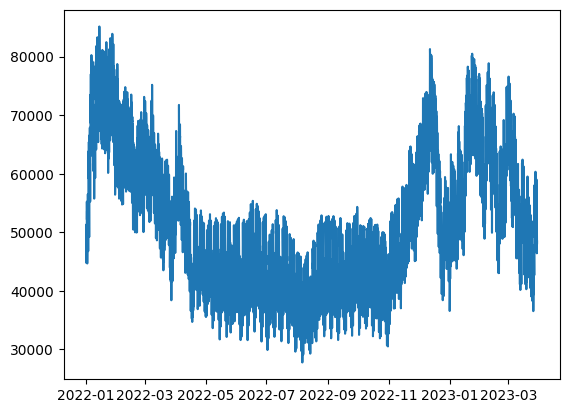

In [17]:
#NEW
x_test_imputed, original_x_test_indices = impute_na(x_test)
null_indices, null_patches, non_null_patches, _, _ = partition_na(x_train['load_forecast'])
longest_patch = sorted(null_patches, key=lambda x:len(x),reverse=True)[0]    
x_train_imputed.loc[pd.DatetimeIndex(longest_patch),'load_forecast'] = x_test_imputed.loc[pd.DatetimeIndex(longest_patch).map(lambda dt: dt.replace(year=2023)),'load_forecast'].values
plt.plot(x_train_imputed['load_forecast'])

`predicted_spot_price` will be learned from available data for training data

In [18]:
x_train_test = pd.concat((x_train,x_test), axis=0)
x_imputed, _ = impute_na(x_train_test)

/tmp/ipykernel_34/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_34/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')
/tmp/ipykernel_34/1171068830.py:143: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


In [19]:
null_indices = x_imputed.loc[x_imputed['predicted_spot_price'].isna()].index
non_null_indices = [i for i in x_imputed.index if i not in null_indices]

In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_spot = x_imputed.loc[non_null_indices,:].drop('predicted_spot_price',axis=1)
y_spot = x_imputed.loc[non_null_indices,'predicted_spot_price']

# Split the data into training and testing sets
X_train_spot, X_test_spot, y_train_spot, y_test_spot = train_test_split(x_spot, y_spot, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_reg = XGBRegressor(objective='reg:squarederror')

# Fit the model on the training data
xgb_reg.fit(X_train_spot, y_train_spot)

# Make predictions on the testing data
y_pred = xgb_reg.predict(X_test_spot)

y_test_with_no_zeros = y_test_spot.replace(0, np.nan)

# Calculate the absolute error
absolute_error = np.abs(y_pred - y_test_with_no_zeros)

# Calculate the relative error
relative_error = absolute_error / y_test_with_no_zeros

# Calculate the mean relative error, excluding any infinite or NaN values due to division by zero
mean_relative_error = np.mean(relative_error.replace([np.inf, -np.inf], np.nan).dropna())

print(f"Mean Relative Error: {mean_relative_error * 100:.2f}%")


Mean Relative Error: 11.22%


In [21]:
null_indices = x_train_imputed.loc[x_train_imputed['predicted_spot_price'].isna()].index

In [22]:
y_pred = xgb_reg.predict(x_train_imputed.drop('predicted_spot_price',axis=1).loc[null_indices,X_train_spot.columns])

In [23]:
x_train_imputed.loc[null_indices, 'predicted_spot_price'] = y_pred

<Axes: xlabel='DELIVERY_START'>

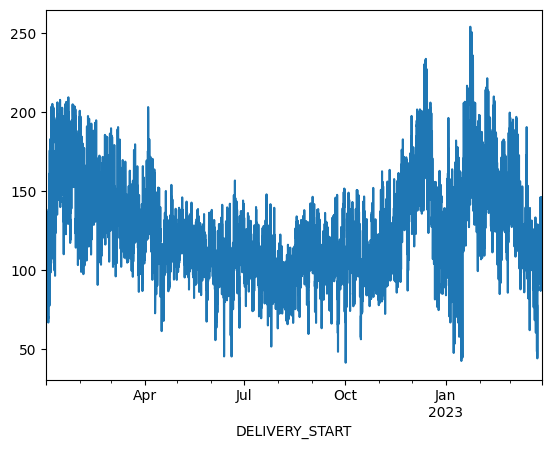

In [24]:
x_train_imputed['predicted_spot_price'].plot()

<Axes: xlabel='DELIVERY_START'>

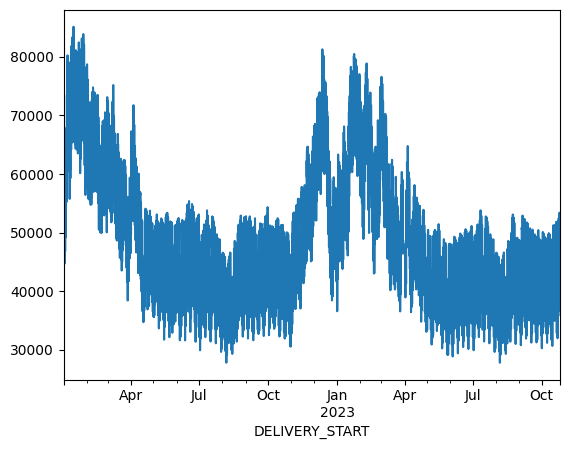

In [25]:
x_train_transition_test = pd.concat((x_train_imputed,x_test_imputed),axis=0).resample('1h').mean().interpolate()
x_train_transition_test['load_forecast'].plot()

In [26]:
y_train_resampled = y_train.resample('1h').mean().fillna(0)
xy_train_resampled = pd.concat((x_train_imputed,y_train_resampled),axis=1)

<strong> Feature Correlation </strong>

In [27]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    
    return plt.show()

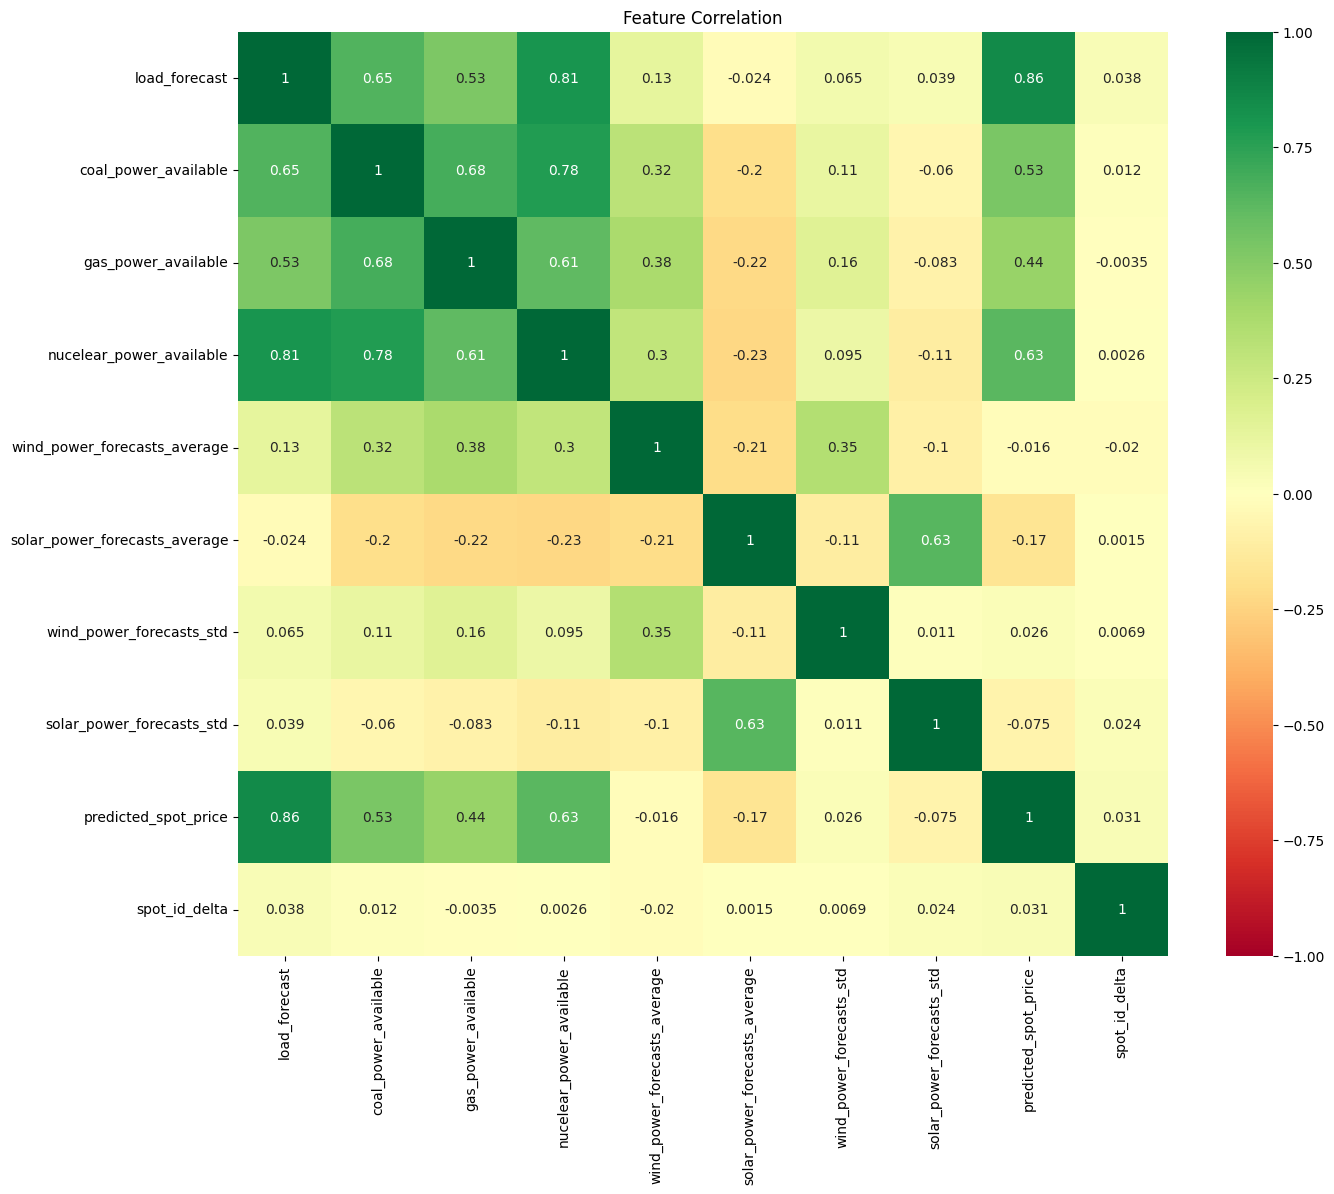

In [28]:
feat_corr(xy_train_resampled)

<h3> Weather dataset </h3>

In [29]:
weather_france = weather_france.resample('1h').mean().interpolate()

In [30]:
weather_y_train = pd.concat((weather_france.loc[x_train_imputed.index,:],y_train_resampled['spot_id_delta']),axis=1)

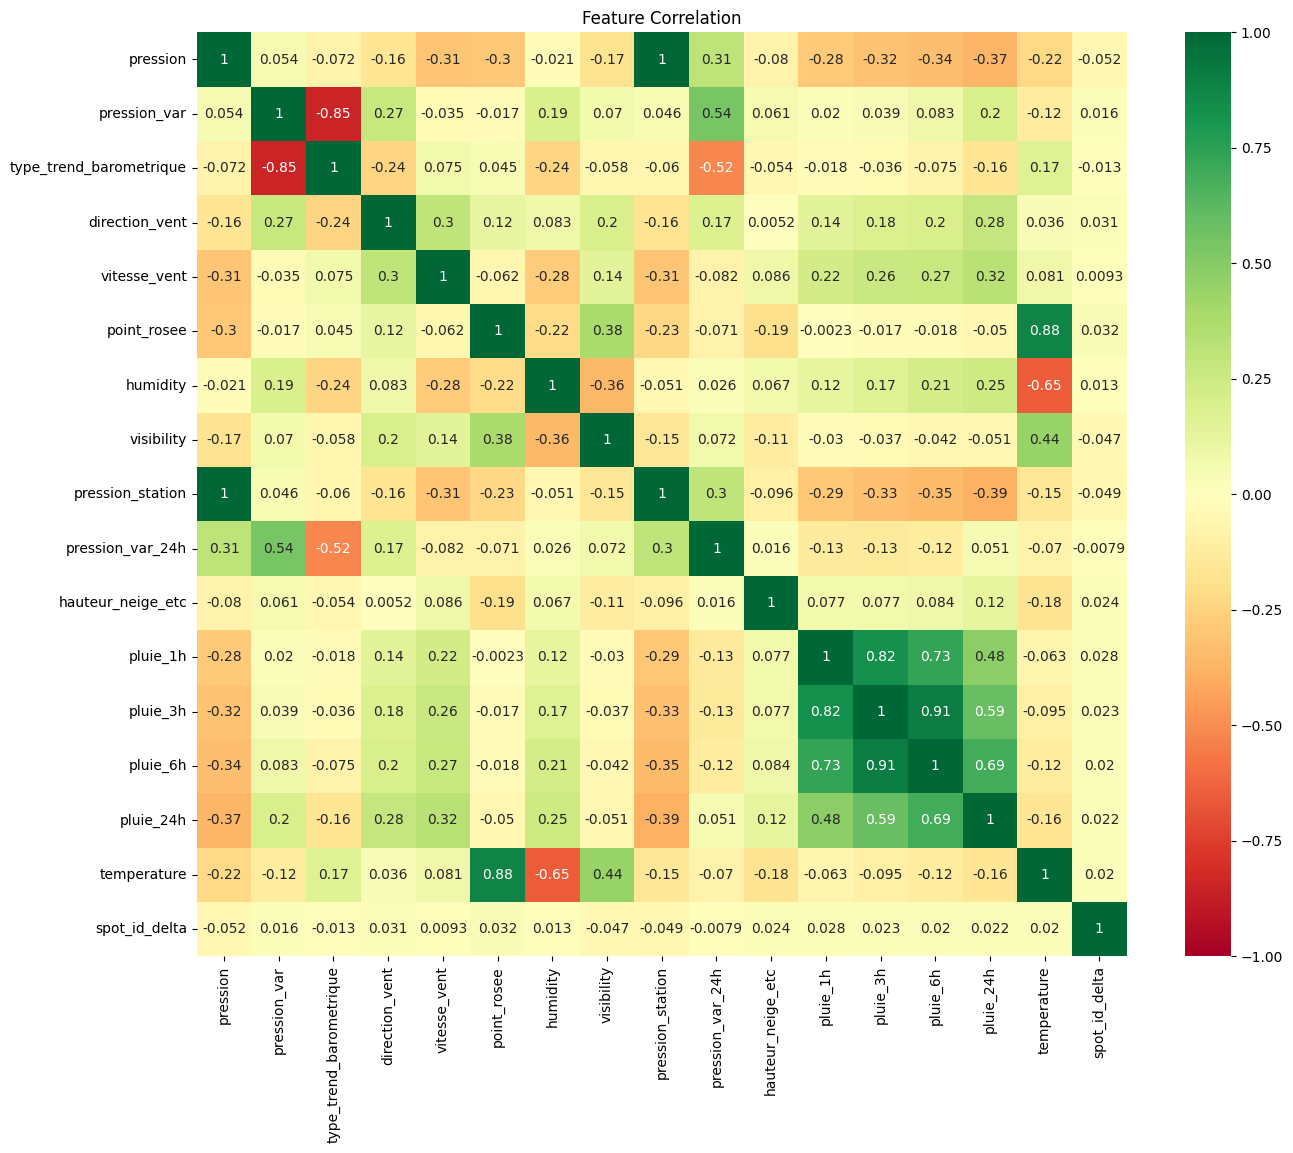

In [31]:
feat_corr(weather_y_train)

In [32]:
to_drop_weather = ['type_trend_barometrique','pression_station','point_rosee']
weather_france.drop(to_drop_weather, axis=1, inplace=True)

In [33]:
x_train_we = pd.concat((x_train_imputed,weather_france.loc[x_train_imputed.index,:]),axis=1) #we=weather_energy
x_test_we = pd.concat((x_test_imputed,weather_france.loc[x_test_imputed.index,:]),axis=1) 
x_train_transition_test_we = pd.concat((x_train_transition_test,weather_france.loc[x_train_transition_test.index,:]),axis=1) 

In [34]:
# JOURNEES SPECIALES -----------------------------------------
#Monday, Saturday, Sunday
x_train_we['monday'] = (x_train_we.index.dayofweek == 0).astype(int)
x_train_we['saturday'] = (x_train_we.index.dayofweek == 5).astype(int)
x_train_we['sunday'] = (x_train_we.index.dayofweek == 6).astype(int)

x_test_we['monday'] = (x_test_we.index.dayofweek == 0).astype(int)
x_test_we['saturday'] = (x_test_we.index.dayofweek == 5).astype(int)
x_test_we['sunday'] = (x_test_we.index.dayofweek == 6).astype(int)

x_train_transition_test_we['monday'] = (x_train_transition_test_we.index.dayofweek == 0).astype(int)
x_train_transition_test_we['saturday'] = (x_train_transition_test_we.index.dayofweek == 5).astype(int)
x_train_transition_test_we['sunday'] = (x_train_transition_test_we.index.dayofweek == 6).astype(int)

In [35]:
!pip install suntimes

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [36]:
# SUNLIGHT -----------------------------------------------------------
from datetime import datetime
from suntimes import SunTimes  
paris = SunTimes(2.349902, 48.852968, 35)

x_train_we['sunrise'] = x_train_we.index.map(lambda x: paris.riseutc(x))
x_train_we['sunset'] = x_train_we.index.map(lambda x: paris.setutc(x))
x_train_we['sunlight'] = 0
x_train_we.loc[(x_train_we.index>= x_train_we.sunrise) & (x_train_we.index<=x_train_we.sunset),'sunlight']=1
x_train_we.drop(['sunrise','sunset'], axis=1, inplace=True)

x_test_we['sunrise'] = x_test_we.index.map(lambda x: paris.riseutc(x))
x_test_we['sunset'] = x_test_we.index.map(lambda x: paris.setutc(x))
x_test_we['sunlight'] = 0
x_test_we.loc[(x_test_we.index>= x_test_we.sunrise) & (x_test_we.index<=x_test_we.sunset),'sunlight']=1
x_test_we.drop(['sunrise','sunset'], axis=1, inplace=True)

x_train_transition_test_we['sunrise'] = x_train_transition_test_we.index.map(lambda x: paris.riseutc(x))
x_train_transition_test_we['sunset'] = x_train_transition_test_we.index.map(lambda x: paris.setutc(x))
x_train_transition_test_we['sunlight'] = 0
x_train_transition_test_we.loc[(x_train_transition_test_we.index>= x_train_transition_test_we.sunrise) & (x_train_transition_test_we.index<=x_train_transition_test_we.sunset),'sunlight']=1
x_train_transition_test_we.drop(['sunrise','sunset'], axis=1, inplace=True)

In [37]:
x_test_we["hour_rad"] = (2*np.pi*x_test_we.index.hour/24) % (2*np.pi)
x_train_we["hour_rad"] = (2*np.pi*x_train_we.index.hour/24) % (2*np.pi)
x_train_transition_test_we["hour_rad"] = (2*np.pi*x_train_transition_test_we.index.hour/24) % (2*np.pi)


In [38]:
!pip install jours_feries_france

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for jours_feries_france: filename=jours_feries_france-0.7.0-py3-none-any.whl size=4980 sha256=40d55d77329cb0fb0acf81248f77800559f835f38798d05e861efa0342ea03fc
  Stored in directory: /root/.cache/pip/wheels/6c/91/19/bc9f25ded8d3f5b48cfa3a01cfce9cf767fc027988e4eee9fb
Successfully built jours_feries_france


In [39]:
# Jours fériés
from jours_feries_france import JoursFeries

holidays = []
for year in [2022, 2023]:
    holidays += list(JoursFeries.for_year(year).values())

x_train_we['holiday'] = 0
for holiday in holidays:
    x_train_we.loc[x_train_we.index.date == holiday, 'holiday'] = 1
x_test_we['holiday'] = 0
for holiday in holidays:
    x_test_we.loc[x_test_we.index.date == holiday, 'holiday'] = 1
x_train_transition_test_we['holiday'] = 0
for holiday in holidays:
    x_train_transition_test_we.loc[x_train_transition_test_we.index.date == holiday, 'holiday'] = 1

In [40]:
x_train_transition_test_we.columns

Index(['load_forecast', 'coal_power_available', 'gas_power_available',
       'nucelear_power_available', 'wind_power_forecasts_average',
       'solar_power_forecasts_average', 'wind_power_forecasts_std',
       'solar_power_forecasts_std', 'predicted_spot_price', 'pression',
       'pression_var', 'direction_vent', 'vitesse_vent', 'humidity',
       'visibility', 'pression_var_24h', 'hauteur_neige_etc', 'pluie_1h',
       'pluie_3h', 'pluie_6h', 'pluie_24h', 'temperature', 'monday',
       'saturday', 'sunday', 'sunlight', 'hour_rad', 'holiday'],
      dtype='object')

<h3> Visualization </h3>

In [41]:
fig = make_subplots()

fig.add_trace(
    go.Line(x=y_train_resampled.index, y=y_train_resampled["spot_id_delta"],
                                name="spot_id_delta"))
fig.add_trace(
    go.Line(x=y_train_resampled.index,y=y_train_resampled.rolling(window=24).mean()["spot_id_delta"],
                                        name="rolling window = daily ave"))
fig.add_trace(
    go.Line(x=y_train_resampled.index,y=y_train_resampled.rolling(window=24*7).mean()["spot_id_delta"],
                                        name="rolling window = weekly ave"))
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<li> So I decompose the price actual into trend, seasonality and residual(noise). for better visualization, 
I ploted 100 first observed seasonality and call it as zoomed seasonality.</li>

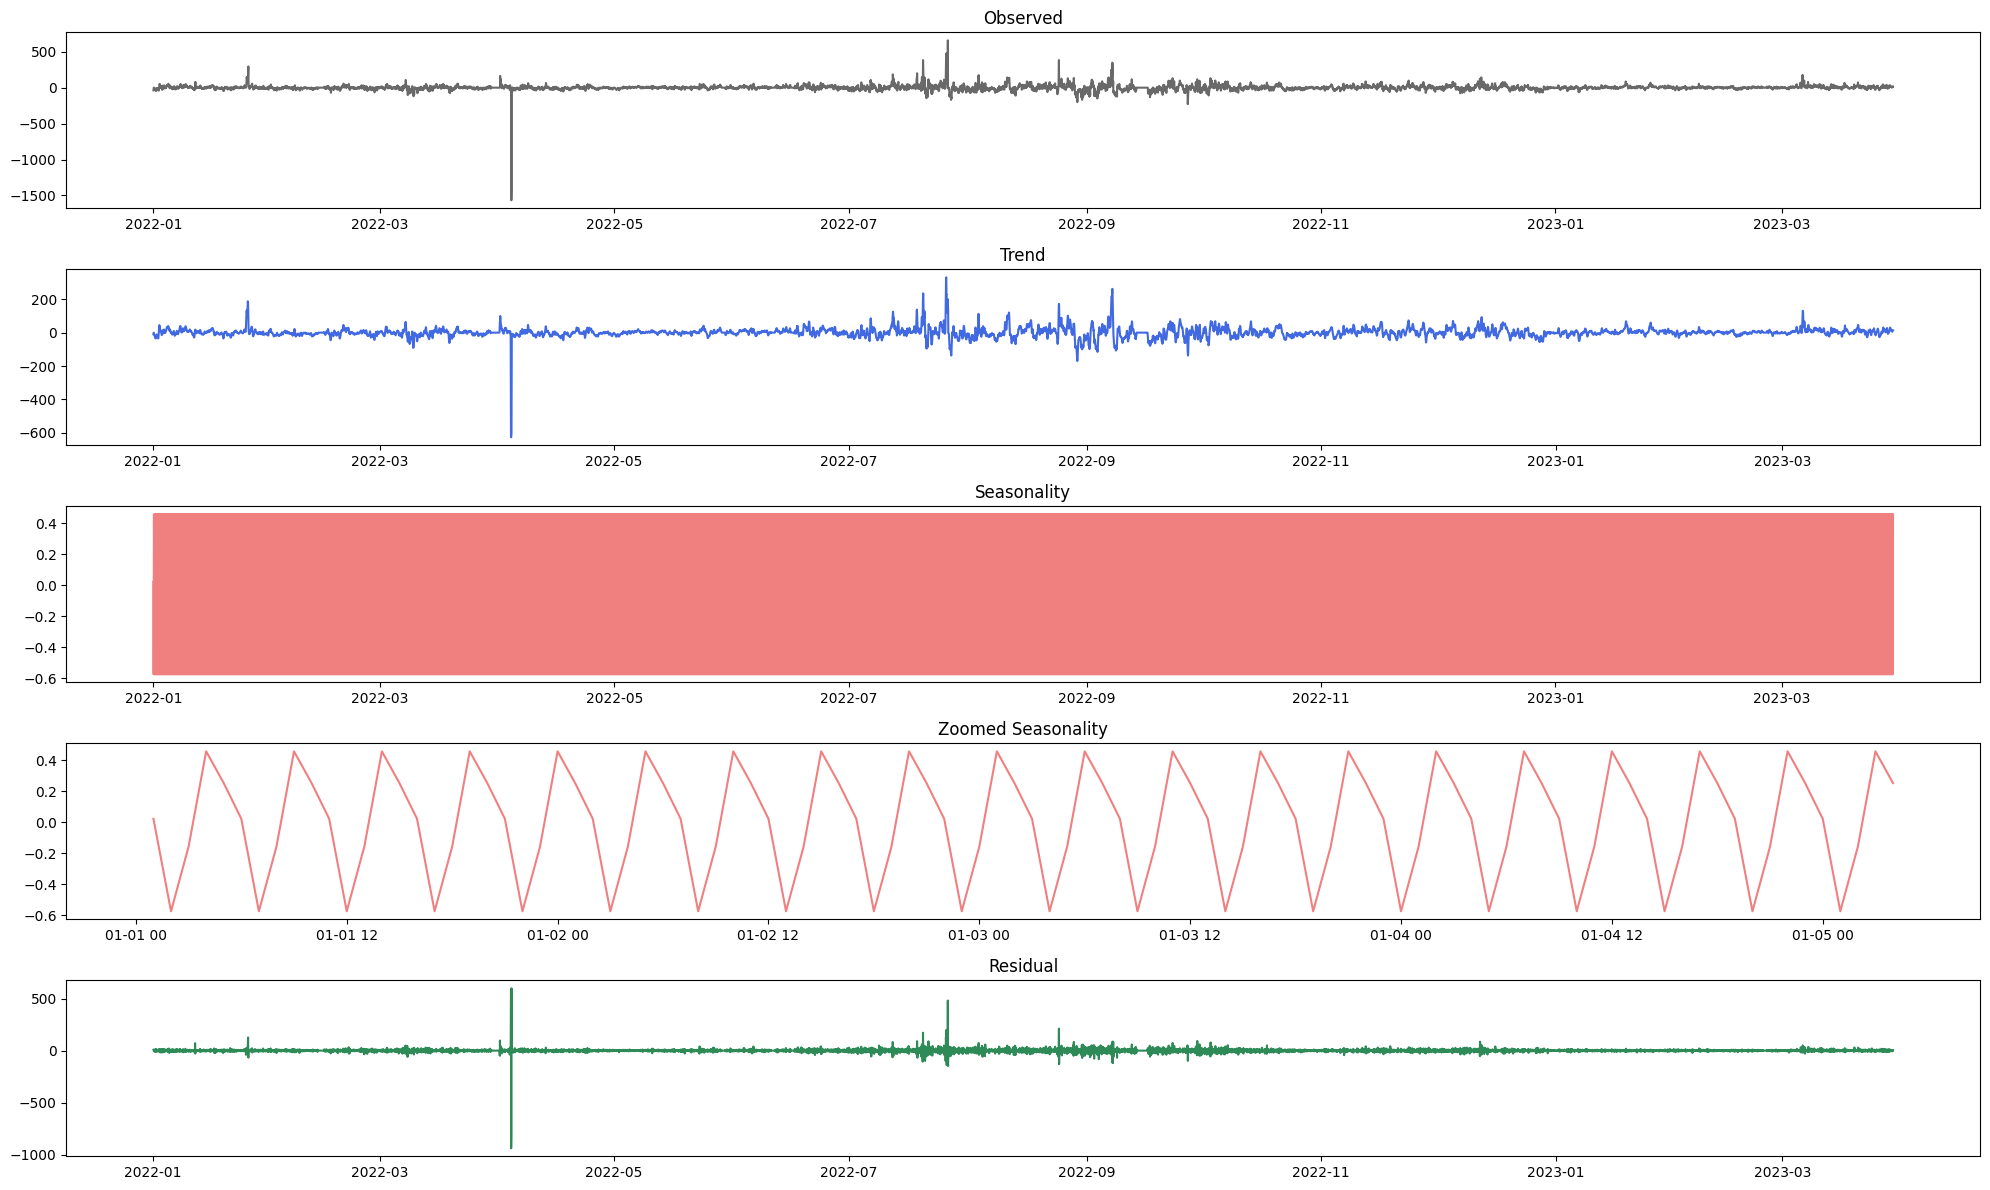

In [42]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = y_train_resampled[["spot_id_delta"]].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()


<li> <strong> The Dickey-Fuller test </strong>, also known as the Augmented Dickey-Fuller (ADF) test, is a statistical test used to 
determine whether a time series is <strong> stationary </strong> or not. Stationarity is an important concept in time series analysis
because it affects the ability to model and predict future values. The test uses a null hypothesis that the time 
series has a unit root, meaning that it is non-stationary. The alternative hypothesis is that the time series 
is stationary. The test statistic is compared to critical values from tables or computed via a statistical 
software package. If the test statistic is less than the critical value, the null hypothesis is rejected, 
and it is concluded that the time series is stationary.</li>
<p>
</p>
<li> In the context of time series analysis, stationarity refers to a property of a time series where the 
statistical properties of the series <strong> do not change over time </strong>. More specifically, a stationary time series is 
one where <strong> the mean, variance, and autocorrelation </strong> structure of the series do not depend on the time at which 
they are computed.</li>
<p>
</p>
<li>The concept of stationarity is important in time series analysis because it simplifies the modeling process and 
enables the use of statistical tools that assume stationarity, such as  <strong>ARMA</strong> (autoregressive moving average) models.
In contrast, non-stationary time series can exhibit trends, seasonality, and other systematic patterns that can 
make it difficult to model and forecast accurately.</li>


In [43]:
result = adfuller(y_train_resampled[["spot_id_delta"]])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -21.055305340511453
p-value: 0.0
Critical Values: {'1%': -3.430952454340349, '5%': -2.8618062512958002, '10%': -2.5669117204317113}


<li> So based on the comments above we can see that the ADF statistics is even lower than the p value with 1% 
significance level. So the time series is considered as stationary! </li>

<li> <strong>Autocorrelation</strong> is a measure of the linear dependence between a time series and its lagged values. It measures 
how strongly the values of a time series at one time are correlated with the values at other times. Autocorrelation 
can be positive (indicating that high values tend to be followed by high values and low values tend to be followed 
by low values) or negative (indicating that high values tend to be followed by low values and vice versa). </li>
<p>
</p>
<li> <strong>Partial autocorrelation</strong>, on the other hand, measures the linear dependence between a time series and its lagged 
values, <strong> after removing the effect of any intermediate lags </strong>. It provides a measure of the direct correlation between 
two time points, taking into account any indirect correlation through intermediate time points. Partial autocorrelation 
can help identify the <strong> order </strong> of an autoregressive (AR) model, which is a model that uses lagged values of the time series 
as predictors. </li>

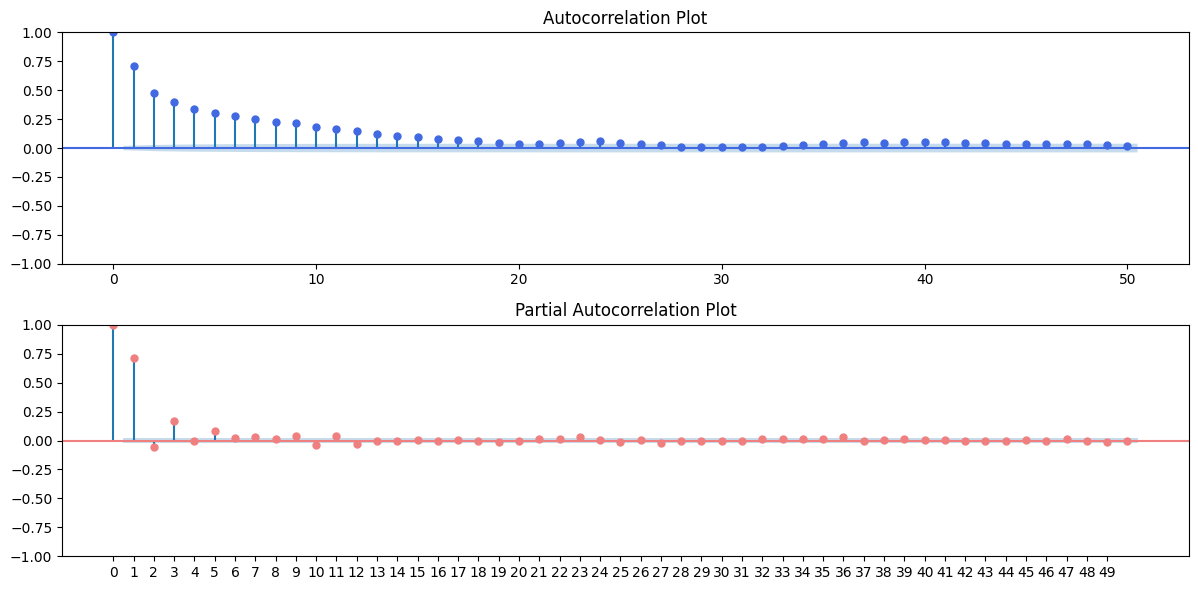

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(y_train_resampled[["spot_id_delta"]], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(y_train_resampled[["spot_id_delta"]], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.xticks(np.arange(0,50,1))
plt.show()

<li> Based on the partial autocorrolation, we have strong correlation of an observation with its past 3 values (after 3,
the correlation becomes very weak). So we use <strong> 25 </strong> lag feature for our time series! </li>

<h3> Dimensionality reduction and train-test split </h3>
<p>
</p>
<li> In this section I applied PCA for dimensionality reduction and add windowing to the dataset to make it prepared as input for tensorflow. I also split the train, validation and test sets and plot it with seperate colors in the figure. 
For faster convergnce and better performance of ML/DL models I normalzed the dataset. </li>

In [45]:
hist_size = 2
X = x_train_we
y = y_train_resampled[["spot_id_delta"]]
X_test = x_train_transition_test_we[x_train_we.shape[0]-hist_size:]


In [46]:
def apply_PCA(X_train, X_val, X_test, cum_variance, if_apply):
    
    if if_apply:
    
        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(StandardScaler(), pca)
        X_pca = scaler_pca.fit(X_train).transform(X_train)
        X_pca_val = scaler_pca.transform(X_val)
        X_pca_test = scaler_pca.transform(X_test)
        X_pca = pd.DataFrame(X_pca, index = X_train.index)
        X_pca_val = pd.DataFrame(X_pca_val, index = X_val.index)
        X_pca_test = pd.DataFrame(X_pca_test, index = X_test.index)
        return X_pca, X_pca_val, X_pca_test
    
    else:
        
        return X_train, X_val, X_test

In [105]:
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[-2000:])
    ax[0].plot(y_test_inv[-2000:])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs actual price for 1000 observation in test set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')
    
    if model != 'hybrid':
    
        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()
    

<li> Normalizing target varialbe, since we already normalized features during the process of applying PCA! </li>

<li> hist_size is the history size equivalent to look back! </li>

## Forecasting

<h3> 1. XGBoost Regressor </h3>

In [253]:
def windowing(X_input,y_input, history_size):
    
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data_sample = np.concatenate((np.array(X_input.iloc[i - history_size : i, :]).flatten(),X_input.iloc[i,:-1]))
        data.append(data_sample)
        labels.append(y_input[i])
    data = np.array(data)
    data = pd.DataFrame(data, index=X_input.iloc[history_size: len(y_input)].index)
    labels = np.array(labels)
    labels = labels.reshape(-1,1)
    labels = pd.DataFrame(labels, y_input.iloc[history_size: len(y_input)].index)
    return data, labels

In [186]:
train_cutoff = int(0.8*X.shape[0])
val_cutoff = int(0.2*X.shape[0])
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
hist_size= 2


X_pca_train, X_pca_val, X_pca_test = apply_PCA(X.iloc[:train_cutoff], X.iloc[-val_cutoff:], X_test, **params_pca)
scaler_y = StandardScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)
y_norm = pd.DataFrame(y_norm, index=y.index)
data_train = pd.concat((X_pca_train, y_norm.iloc[:train_cutoff]), axis = 1)
data_val = pd.concat((X_pca_val, y_norm.iloc[-val_cutoff:]), axis=1)

X_train_, y_train_ = windowing(data_train,data_train.iloc[:,-1], hist_size)
X_val_, y_val_     = windowing(data_val,data_val.iloc[:,-1], hist_size)
X_train_xgb = X_train_
X_val_xgb   = X_val_

/tmp/ipykernel_34/1079079876.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [187]:
xgb_model = xgb.XGBRegressor(eval_metric='mae',n_estimators = 100)

# Fit the model
xgb_model.fit(X_train_xgb, y_train_,
              eval_set=[(X_train_xgb, y_train_), (X_val_xgb, y_val_)],
              early_stopping_rounds=8,
               verbose=False) 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)



---------------------------------------------------
XGBoost MAE for validation set : 0.15
---------------------------------------------------



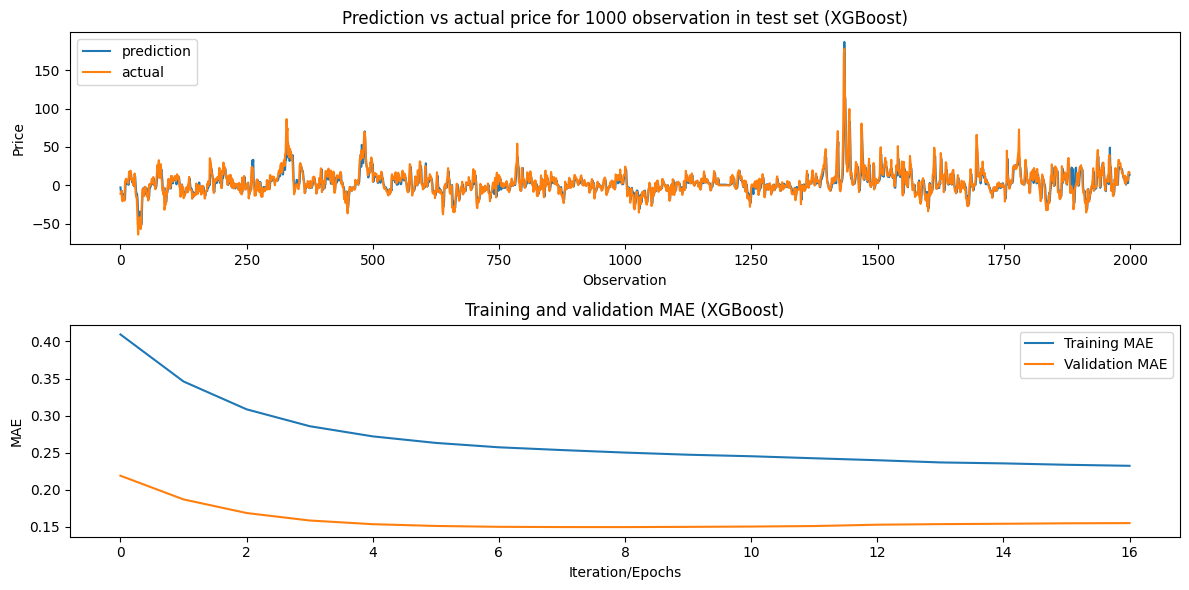

In [188]:
y_pred = xgb_model.predict(X_val_xgb)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_val_inv = scaler_y.inverse_transform(y_val_)
y_pred_cls = (y_pred>0).astype(int)*2-1

print('')
print('')
print('---------------------------------------------------')
print(f'XGBoost MAE for validation set : {round(mean_absolute_error(y_pred,y_val_),3)}')
print('---------------------------------------------------')
print('')
plot_results(y_pred_actual, y_val_inv, xgb_model,'XGBoost')

In [189]:
def weighted_accuracy(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    return np.sum(((y_true * y_pred) > 0) * np.abs(y_true)) / np.sum(np.abs(y_true))

In [190]:
weighted_accuracy(y_val_,y_pred_cls)

0.9292310031077972

In [191]:
hist_size= 2
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }

#History -- initialisation
X_pca_val_new = pd.concat((X_pca_train.iloc[-hist_size:,:], X_pca_val), axis=0)
y_val_pred = pd.DataFrame(np.zeros(X_pca_val.shape[0]), index=X_pca_val.index)
y_norm_val = pd.concat((y_train_.iloc[-hist_size:],y_val_pred), axis=0)
data = pd.concat((X_pca_val_new,y_norm_val),axis=1)

#Sequential prediction
for i in range(hist_size, data.shape[0]):
    x = np.concatenate((np.array(data.iloc[i-hist_size:i,:]).flatten(),data.iloc[i,:-1]))
    x = pd.DataFrame(x.reshape(1,-1), index=[data.index[i]])
    data.iloc[i,-1] = xgb_model.predict(x)
y_pred = np.array(data.iloc[4:,-1])


In [192]:
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_val_inv = scaler_y.inverse_transform(y_val_)
y_pred_actual_cls = (y_pred_actual>0).astype(int)*2-1

In [193]:
weighted_accuracy(y_val_inv, y_pred_actual_cls)

0.6040218652689909

0.6926611601680251

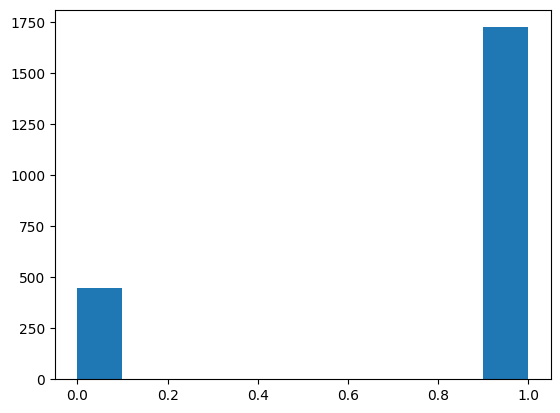

In [160]:
plt.hist((y_pred_actual>0).astype(int))
np.mean(y_pred_actual)

<h3> 2. XGBoost Classifier <\h3>

In [254]:
binary = True
hist_size = 2
X = x_train_we
y = y_train_resampled[["spot_id_delta"]]
y_cls = y.copy()

if not binary:
    bins = [-np.inf, -72, -38, 0, 38, 72, np.inf]
    for i in range(y.shape[0]):
        if y.iloc[i,0] <= bins[1]:
            y_cls.iloc[i,0] = 0  
        elif y.iloc[i,0] <= bins[2]:
            y_cls.iloc[i,0] = 1 
        elif y.iloc[i,0] <= bins[3]:
            y_cls.iloc[i,0] = 2 
        elif y.iloc[i,0] <= bins[4]:
            y_cls.iloc[i,0] = 3 
        elif y.iloc[i,0] <= bins[5]:
            y_cls.iloc[i,0] = 4 
        else:
            y_cls.iloc[i,0] = 5 
else:
    y_cls = (y>0).astype(int)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



<Axes: ylabel='Count'>

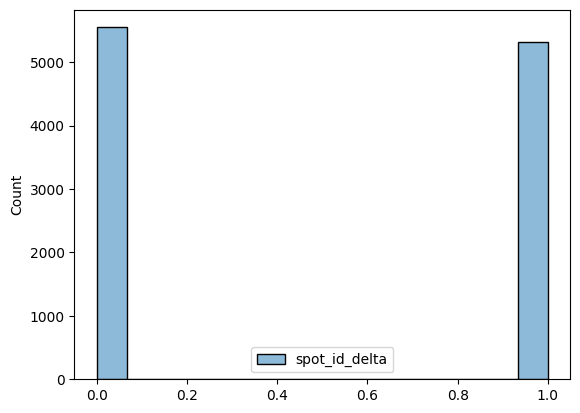

In [255]:
sns.histplot(y_cls)

In [263]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
np.seterr(invalid='ignore')

split = 0.8
train_cutoff = int(split*X.shape[0])
val_cutoff = int(0.2*X.shape[0])
params_pca = {'cum_variance' : 0.7, 'if_apply' : True }
X_pca_train, X_pca_val, X_pca_test = apply_PCA(X.iloc[:train_cutoff], X.iloc[-val_cutoff:], X_test, **params_pca)
data_train = pd.concat((X_pca_train, y_cls.iloc[:train_cutoff]), axis = 1)
data_val = pd.concat((X_pca_val, y_cls.iloc[-val_cutoff:]), axis=1)
X_train_xgb, y_train_cls = windowing(data_train,data_train.iloc[:,-1], hist_size)
X_val_xgb, y_val_cls     = windowing(data_val,data_val.iloc[:,-1], hist_size)
y_train_ = y.iloc[:train_cutoff][hist_size:]
y_val_ = y.iloc[-val_cutoff:][hist_size:]

xgb_model = xgb.XGBClassifier(n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_cls,
          eval_set=[(X_train_xgb, y_train_cls), (X_val_xgb, y_val_cls)],
          early_stopping_rounds=8,
           verbose=False) 

#History -- initialisation
X_pca_val_new = pd.concat((X_pca_train.iloc[-hist_size:,:], X_pca_val), axis=0)
y_val_pred = pd.DataFrame(np.zeros(X_pca_val.shape[0]), index=X_pca_val.index)
y_norm_val = pd.concat((y_train_cls.iloc[-hist_size:],y_val_pred), axis=0)
data = pd.concat((X_pca_val_new,y_norm_val),axis=1)

#Sequential prediction
for i in range(hist_size, data.shape[0]):
    x = np.concatenate((np.array(data.iloc[i-hist_size:i,:]).flatten(),data.iloc[i,:-1]))
    x = pd.DataFrame(x.reshape(1,-1), index=[data.index[i]])
    data.iloc[i,-1] = xgb_model.predict(x)
y_pred = np.array(data.iloc[4:,-1])
if binary:
    y_pred = y_pred*2-1
else:
    y_pred = y_pred*2-5
print(f'{split} :  {weighted_accuracy(y_val_, y_pred)}')

/tmp/ipykernel_34/1079079876.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8 :  0.6823533534223806


(array([ 501.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1670.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

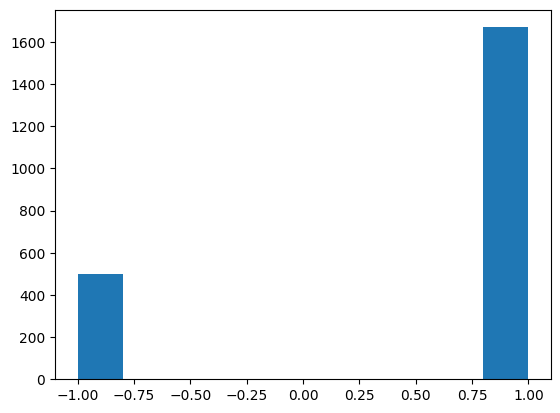

In [257]:
plt.hist(y_pred)

In [264]:
y_pred = xgb_model.predict(X_val_xgb)
y_pred = y_pred*2-1
weighted_accuracy(y_val_,y_pred)


0.9281680366030479

<h3> 3. GRU (Regression) </h3>

In [166]:
def windowing(X_input,y_input, history_size):
    
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input.iloc[i - history_size : i, :])
        labels.append(y_input.iloc[i])
    data = np.array(data)
    data_index = X_input.iloc[history_size: len(y_input)].index
    labels = np.array(labels)
    labels = labels.reshape(-1,1)
    labels = pd.DataFrame(labels, y_input.iloc[history_size: len(y_input)].index)
    return data, labels

In [173]:
train_cutoff = int(0.8*X.shape[0])
val_cutoff = int(0.2*X.shape[0])
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
hist_size= 2


X_pca_train, X_pca_val, X_pca_test = apply_PCA(X.iloc[:train_cutoff], X.iloc[-val_cutoff:], X_test, **params_pca)
scaler_y = StandardScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)
y_norm = pd.DataFrame(y_norm, index=y.index)
data_train = pd.concat((X_pca_train, y_norm.iloc[:train_cutoff]), axis = 1)
data_val = pd.concat((X_pca_val, y_norm.iloc[-val_cutoff:]), axis=1)

X_train_, y_train_ = windowing(data_train,data_train.iloc[:,-1], hist_size)
X_val_, y_val_     = windowing(data_val,data_val.iloc[:,-1], hist_size)
X_train_xgb = X_train_
X_val_xgb   = X_val_

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Flatten, Dense, Dropout

def base_model_gru():
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train_.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))  # Change for binary classification
    
    return model
# Assuming X_train_ is defined and available in your environment
gru_model = base_model_gru()

In [175]:
# inputs for DL models
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train_) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)

In [ ]:
step = np.arange(0, epoch * steps_per_epoch)
lr = cyclic_lr(step)


In [178]:
# Compile the model
gru_model.compile(optimizer='adam', loss='mae')
history = gru_model.fit(X_train_, y_train_, validation_data = (X_val_, y_val_), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
136/136 [==============================] - 2s 6ms/step - loss: 0.2721 - val_loss: 2.5670
Epoch 2/100
136/136 [==============================] - 1s 4ms/step - loss: 0.2696 - val_loss: 2.5441
Epoch 3/100
136/136 [==============================] - 1s 4ms/step - loss: 0.2695 - val_loss: 2.5872
Epoch 4/100
136/136 [==============================] - 1s 4ms/step - loss: 0.2691 - val_loss: 2.5458
Epoch 5/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2693 - val_loss: 2.5977
Epoch 6/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2676 - val_loss: 2.5557
Epoch 7/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2663 - val_loss: 2.5780
Epoch 8/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2658 - val_loss: 2.5855
Epoch 9/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2667 - val_loss: 2.5754
Epoch 10/100
136/136 [==============================] - 1s 5ms/step - loss: 0.2661 - val_lo



---------------------------------------------------
GRU MAE for test set : 0.186
---------------------------------------------------



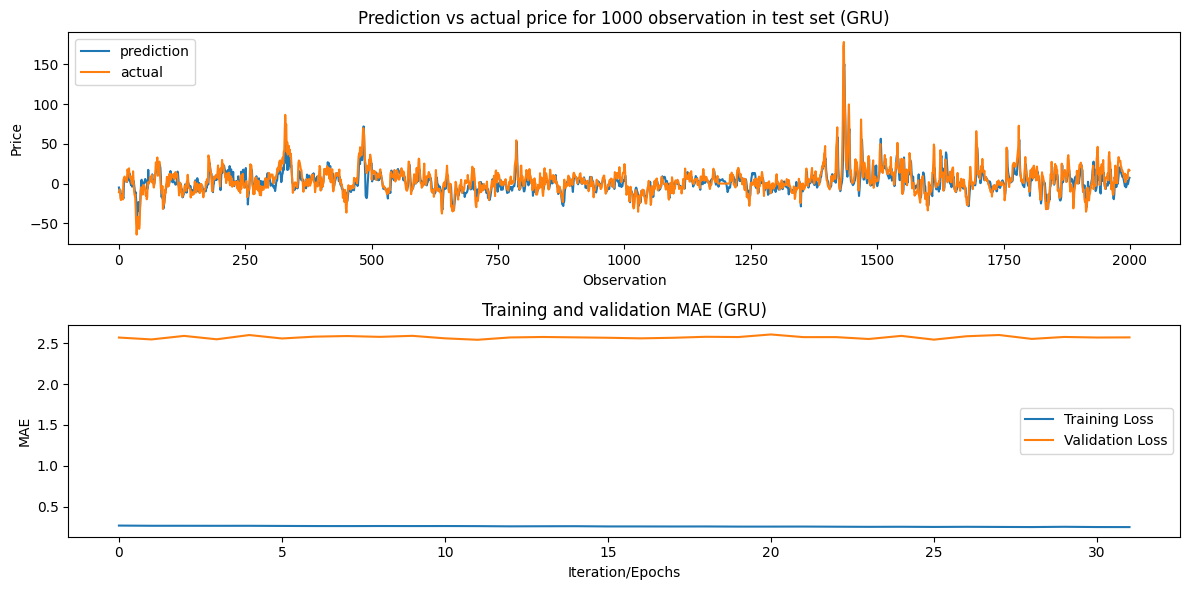

In [179]:
y_pred = gru_model.predict(X_val_)
print('')
print('')
print('---------------------------------------------------')
print(f'GRU MAE for test set : {round(mean_absolute_error(y_pred,y_val_),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_val_inv = scaler_y.inverse_transform(y_val_)
print('')
plot_results(y_pred_actual, y_val_inv, history,'GRU')

In [180]:
y_pred = gru_model.predict(X_val_)
y_pred.shape

(2171, 1)

In [182]:
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_val_inv = scaler_y.inverse_transform(y_val_)
y_pred_actual_cls = (y_pred_actual>0).astype(int)*2-1
weighted_accuracy(y_val_inv, y_pred_actual_cls)

0.8687723407624176

In [183]:
hist_size= 2
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }

#History -- initialisation
X_pca_val_new = pd.concat((X_pca_train.iloc[-hist_size:,:], X_pca_val), axis=0)
y_val_pred = pd.DataFrame(np.zeros(X_pca_val.shape[0]), index=X_pca_val.index)
y_norm_val = pd.concat((y_train_cls.iloc[-hist_size:],y_val_pred), axis=0)
print(y_norm_val.shape)
data = pd.concat((X_pca_val_new,y_norm_val),axis=1)

#Sequential prediction
for i in range(hist_size, data.shape[0]):
    x = np.expand_dims(data.iloc[i-hist_size:i,:],0)
    data.iloc[i,-1] = np.argmax(gru_model.predict(x),axis=1)

y_pred = np.array(data.iloc[4:,-1])


(2175, 1)


In [184]:
y_pred = y_pred*2-1
weighted_accuracy(y_val_inv, y_pred)

0.3447310000576528

<h3> 4. LSTM </h3>
Classification

In [198]:
def windowing(X_input,y_input, history_size):
    
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input.iloc[i - history_size : i, :])
        labels.append(y_input.iloc[i])
    data = np.array(data)
    data_index = X_input.iloc[history_size: len(y_input)].index
    labels = np.array(labels)
    labels = labels.reshape(-1,1)
    labels = pd.DataFrame(labels, y_input.iloc[history_size: len(y_input)].index)
    return data, labels

In [202]:
train_cutoff = int(0.8*X.shape[0])
val_cutoff = int(0.2*X.shape[0])
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
hist_size= 2
y_cls = (y>0).astype(int)
y_val_ = y.iloc[-val_cutoff:]
y_train_ = y.iloc[:train_cutoff]
X_pca_train, X_pca_val, X_pca_test = apply_PCA(X.iloc[:train_cutoff], X.iloc[-val_cutoff:], X_test, **params_pca)
data_train = pd.concat((X_pca_train, y_cls.iloc[:train_cutoff]), axis = 1)
data_val = pd.concat((X_pca_val, y_cls.iloc[-val_cutoff:]), axis=1)

X_train_, y_train_cls = windowing(data_train,data_train.iloc[:,-1], hist_size)
X_val_, y_val_cls     = windowing(data_val,data_val.iloc[:,-1], hist_size)

In [203]:
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, activation="relu", input_shape = X_train_.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 2, 32)             5888      
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________


In [204]:
history = lstm_model.fit(X_train_, y_train_cls, validation_data = (X_val_, y_val_cls), epochs =epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
136/136 [==============================] - 3s 8ms/step - loss: 0.5049 - accuracy: 0.7853 - val_loss: 0.4637 - val_accuracy: 0.8236
Epoch 2/100
136/136 [==============================] - 1s 5ms/step - loss: 0.4571 - accuracy: 0.8238 - val_loss: 0.4767 - val_accuracy: 0.8263
Epoch 3/100
136/136 [==============================] - 1s 5ms/step - loss: 0.4490 - accuracy: 0.8238 - val_loss: 0.4648 - val_accuracy: 0.8287
Epoch 4/100
136/136 [==============================] - 1s 6ms/step - loss: 0.4430 - accuracy: 0.8249 - val_loss: 0.4633 - val_accuracy: 0.8259
Epoch 5/100
136/136 [==============================] - 1s 5ms/step - loss: 0.4363 - accuracy: 0.8251 - val_loss: 0.4704 - val_accuracy: 0.8273
Epoch 6/100
136/136 [==============================] - 1s 5ms/step - loss: 0.4273 - accuracy: 0.8253 - val_loss: 0.4697 - val_accuracy: 0.8250
Epoch 7/100
136/136 [==============================] - 1s 5ms/step - loss: 0.4210 - accuracy: 0.8271 - val_loss: 0.4731 - val_accuracy: 0.8222

In [209]:
y_pred = lstm_model.predict(X_val_)

In [210]:
y_pred = y_pred*2-1
weighted_accuracy(y_val_[2:],y_pred)

0.9024516668445102

In [211]:
hist_size= 2
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }

#History -- initialisation
X_pca_val_new = pd.concat((X_pca_train.iloc[-hist_size:,:], X_pca_val), axis=0)
y_val_pred = pd.DataFrame(np.zeros(X_pca_val.shape[0]), index=X_pca_val.index)
y_norm_val = pd.concat((y_train_cls.iloc[-hist_size:],y_val_pred), axis=0)
print(y_norm_val.shape)
data = pd.concat((X_pca_val_new,y_norm_val),axis=1)

#Sequential prediction
for i in range(hist_size, data.shape[0]):
    x = np.expand_dims(data.iloc[i-hist_size:i,:],0)
    data.iloc[i,-1] = lstm_model.predict(x)

y_pred = np.array(data.iloc[4:,-1])


(2175, 1)


In [214]:
y_pred = np.array(data.iloc[2:,-1])
y_pred

array([0.29620242, 0.49396622, 0.63741934, ..., 0.13684124, 0.10666391,
       0.24578199])

In [215]:
y_pred = (y_pred>0.5).astype(int)*2-1
weighted_accuracy(y_val_, y_pred)

0.48593639775080466

<h3> 5. LSTM (Regression) </h3>

In [219]:
train_cutoff = int(0.8*X.shape[0])
val_cutoff = int(0.2*X.shape[0])
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
hist_size= 25
X_pca_train, X_pca_val, X_pca_test = apply_PCA(X.iloc[:train_cutoff], X.iloc[-val_cutoff:], X_test, **params_pca)
data_train = pd.concat((X_pca_train, y_norm.iloc[:train_cutoff]), axis = 1)
data_val = pd.concat((X_pca_val, y_norm.iloc[-val_cutoff:]), axis=1)

X_train_, y_train_ = windowing(data_train,data_train.iloc[:,-1], hist_size)
X_val_, y_val_     = windowing(data_val,data_val.iloc[:,-1], hist_size)

In [220]:
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, activation="relu", input_shape = X_train_.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mae')
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 25, 32)            5888      
                                                                 
 flatten_11 (Flatten)        (None, 800)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               102528    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 108,545
Trainable params: 108,545
Non-trainable params: 0
_________________________________________________________________


In [221]:
history = lstm_model.fit(X_train_, y_train_, validation_data = (X_val_, y_val_), epochs =epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
136/136 [==============================] - 5s 23ms/step - loss: 0.4629 - val_loss: 0.2571
Epoch 2/100
136/136 [==============================] - 3s 19ms/step - loss: 0.3747 - val_loss: 0.2563
Epoch 3/100
136/136 [==============================] - 3s 19ms/step - loss: 0.3384 - val_loss: 0.2443
Epoch 4/100
136/136 [==============================] - 3s 19ms/step - loss: 0.3204 - val_loss: 0.2340
Epoch 5/100
136/136 [==============================] - 3s 19ms/step - loss: 0.3066 - val_loss: 0.2278
Epoch 6/100
136/136 [==============================] - 3s 19ms/step - loss: 0.2972 - val_loss: 0.2226
Epoch 7/100
136/136 [==============================] - 3s 20ms/step - loss: 0.2892 - val_loss: 0.2236
Epoch 8/100
136/136 [==============================] - 3s 19ms/step - loss: 0.2827 - val_loss: 0.2191
Epoch 9/100
136/136 [==============================] - 3s 19ms/step - loss: 0.2778 - val_loss: 0.2212
Epoch 10/100
136/136 [==============================] - 3s 19ms/step - loss: 0.277

In [226]:
y_pred = lstm_model.predict(X_val_)

In [227]:
y_pred = (y_pred>0).astype(int)*2-1
weighted_accuracy(y_val_,y_pred)

0.8106022811046759

In [246]:
hist_size= 25
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }

#History -- initialisation
X_pca_val_new = pd.concat((X_pca_train.iloc[-hist_size:,:], X_pca_val), axis=0)
y_val_pred = pd.DataFrame(np.zeros(X_pca_val.shape[0]), index=X_pca_val.index)
y_norm_val = pd.concat((y_train_cls.iloc[-hist_size:],y_val_pred), axis=0)
print(y_norm_val.shape)
data = pd.concat((X_pca_val_new,y_norm_val),axis=1)

#Sequential prediction
for i in range(hist_size, data.shape[0]):
    x = np.expand_dims(data.iloc[i-hist_size:i,:],0)
    data.iloc[i,-1] = lstm_model.predict(x)

(2198, 1)


(array([  6.,  14.,  32., 124., 592., 860., 316., 179.,  38.,  12.]),
 array([-1.58441937, -1.29700882, -1.00959828, -0.72218773, -0.43477719,
        -0.14736664,  0.1400439 ,  0.42745445,  0.71486499,  1.00227554,
         1.28968608]),
 <BarContainer object of 10 artists>)

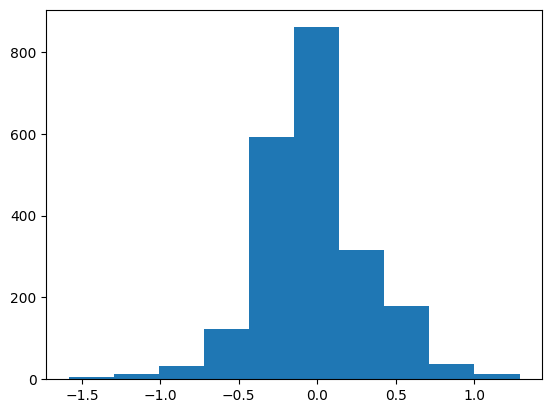

In [247]:
y_pred = np.array(data.iloc[25:,-1])
plt.hist(y_pred)

In [248]:
y_pred = (y_pred>0).astype(int)*2-1
weighted_accuracy(y_val_, y_pred[25:])

0.48599780047591484

# Submission

## XGboost

In [161]:
hist_size= 2
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }

#History -- initialisation
X_pca_test_new = pd.concat((X_pca_val.iloc[-hist_size:,:], X_pca_test), axis=0)
y_test_pred = pd.DataFrame(np.zeros(X_pca_test.shape[0]), index=X_pca_test.index)
y_norm_test = pd.concat((y_val_.iloc[-hist_size:],y_test_pred), axis=0)
data = pd.concat((X_pca_test_new,y_norm_test),axis=1)

#Sequential prediction
for i in range(hist_size, data.shape[0]):
    x = np.concatenate((np.array(data.iloc[i-hist_size:i,:]).flatten(),data.iloc[i,:-1]))
    x = pd.DataFrame(x.reshape(1,-1), index=[data.index[i]])
    data.iloc[i,-1] = xgb_model.predict(x)

In [162]:
y_pred_test = data.loc[original_x_test_indices].iloc[:,-1]
y_pred_test = pd.DataFrame(y_pred_test).rename(columns={0:'spot_id_delta'})
y_pred_test['spot_id_delta'] = scaler_y.inverse_transform(np.array(y_pred_test['spot_id_delta']).reshape(-1,1))
np.mean(y_pred_test['spot_id_delta'])

1.4580115792045079

mean 1.4580115792045079
std 4.320513728533758


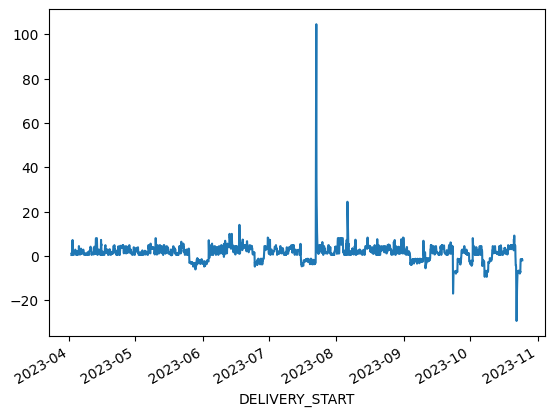

In [163]:
y_pred_test['spot_id_delta'].plot()
print('mean', np.mean(y_pred_test['spot_id_delta']))
print('std', np.std(y_pred_test['spot_id_delta']))

In [164]:
y_test_pred = (y_pred_test['spot_id_delta']>0).astype(int)*2 -1
submission = pd.DataFrame(y_test_pred, index=x_test_raw.index, columns=['spot_id_delta'])
model_name = 'XGBoost'
submission.to_csv(f'{model_name}.csv', index=True)

(array([1003.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3939.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

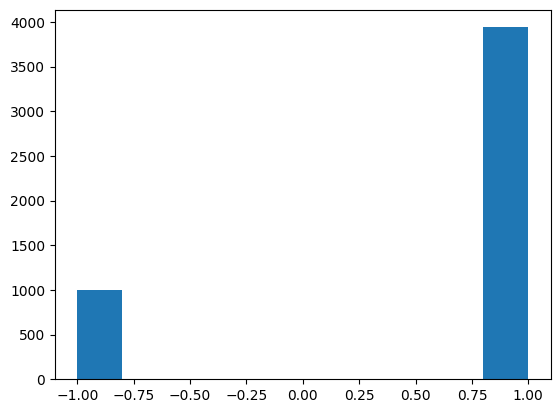

In [165]:
plt.hist(y_test_pred)

## Deep Learning